# HW 2
In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).
The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [38]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## EDA


<Axes: >

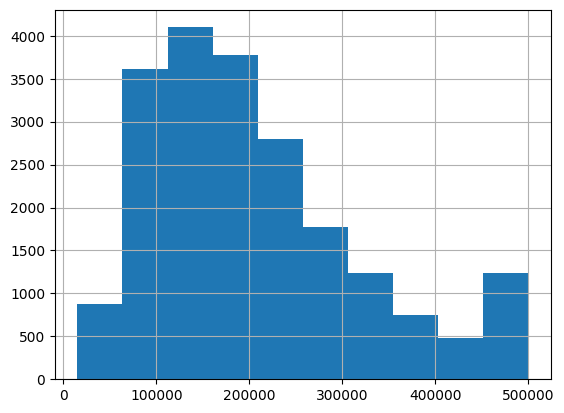

In [40]:
df.median_house_value.hist()

## Prepare the dataset

In [41]:
selected_columns = ['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
df = df.loc[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND']), selected_columns]
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


## Q1
There's one feature with missing values. What is it?

total_bedrooms

In [42]:
df.isna().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

## Q2
What's the median (50% percentile) for variable 'population'?

In [43]:
median_population = df['population'].median()
print(median_population)

1195.0


## Prepare and split the dataset
Shuffle the initial dataset, use seed 42.

Split your data in train/val/test sets, with 60%/20%/20% distribution.

Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [44]:
np.random.seed(42)
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [45]:
y_train_orig = df_train.median_house_value.values
y_val_orig = df_val.median_house_value.values
y_test_orig = df_test.median_house_value.values

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

## Q3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- With 0
- With mean
- Both are equally good

In [46]:
# Linear Regression
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [47]:
def prepare_X(df, method):
    if method == 'zero':
        df = df.fillna(0)
    else:
        df = df.fillna(df.mean())
    X = df.values
    return X

In [48]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [49]:
# fill with 0
X_train = prepare_X(df_train, 'zero')
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
round(rmse(y_train, y_pred), 2)

0.34

In [50]:
# fill with mean
X_train = prepare_X(df_train, 'mean')
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)
round(rmse(y_train, y_pred),2)


0.34

Both are equally good. If not rounded, filling with mean has slightly lower RMSE than filling with zero.

## Q4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [51]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [52]:
X_train = prepare_X(df_train, 'zero')
X_val = prepare_X(df_val, 'zero')

In [53]:

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, round(rmse(y_val, y_pred),2))

     0 0.34
 1e-06 0.34
0.0001 0.34
 0.001 0.34
  0.01 0.34
   0.1 0.34
     1 0.34
     5 0.35
    10 0.35


0 give the lowest rmse

## Q5
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 0.5
- 0.05
- 0.005
- 0.0005

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [61]:
rmse_list = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    n = len(df)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)
    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    y_train_orig = df_train.median_house_value.values
    y_val_orig = df_val.median_house_value.values
    y_test_orig = df_test.median_house_value.values

    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)

    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
    X_train = prepare_X(df_train, 'zero')
    X_val = prepare_X(df_val, 'zero')

    w_0, w = train_linear_regression(X_train, y_train)
    y_pred = w_0 + X_val.dot(w)
    print(seed, rmse(y_val, y_pred))
    rmse_list.append(rmse(y_val, y_pred))


0 0.3377387160082512
1 0.3377999353662671
2 0.33842870067715325
3 0.33200494683064413
4 0.3394451862555799
5 0.3433819705287994
6 0.3385330211770828
7 0.34687476972931436
8 0.3512736865968845
9 0.33415582665298454


In [62]:
round(np.std(rmse_list),3)

0.005

## Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 0.13
- 0.23
- 0.33
- 0.43

In [68]:
np.random.seed(9)
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

df_combined = pd.concat([df_train, df_val])
y_train = np.log1p(df_combined.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)
del df_combined['median_house_value']
del df_test['median_house_value']
X_train = prepare_X(df_combined, 'zero')
X_test = prepare_X(df_test, 'zero')

w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w_0 + X_test.dot(w)
round(rmse(y_test, y_pred),2)

0.33